# **ProteomicsDB and CCLE **

Author: Minji Jeon

Date: Feb. 2020

Data Source: https://doi.org/10.1093/nar/gkz974, https://www.cell.com/cell/fulltext/S0092-8674(19)31385-6

In [1]:
import sys, datetime, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.distributions.empirical_distribution import ECDF
%matplotlib inline

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def save(obj, path, name, is_list=False):
    if is_list == True:
        with open(path+name, "w") as f:
            for line in obj:
                f.write("\t".join(line))
                f.write("\n")
                f.flush()
    else:
        obj.to_csv(path+name, sep="\t")
    print("SAVED! {}".format(path+name))


## Load datasets

Choose dataset_name as CCLE or proteomicsdb

In [25]:
dataset_name = "proteomicsdb"
# dataset_name = "CCLE"

if dataset_name == "proteomicsdb":
    filepath = "./data/"
    protein_expression_df = pd.read_csv(filepath+"ProteomicsDB_proteinspertissue_pivoted.tsv", sep="\t", index_col=0).T

    protein_id_df = pd.read_csv(filepath+"ProteomicsDB_protein_id.csv", index_col=0)
    protein_id_df.columns = ["GeneSym", "Uniprot_Acc"]
    
else:    
    filepath = "./data/"
    df = pd.read_csv(filepath+"mmc2.csv")
    


## Uniprot ID to Gene name if proteomicsdb

In [26]:
if dataset_name == "proteomicsdb":
    uniprot_id_gene_name_df = pd.read_csv(filepath+"uniprot_id_to_gene_name.tsv", sep="\t")
    uniprot_id_gene_name_dict = dict(zip(uniprot_id_gene_name_df["From"], uniprot_id_gene_name_df["To"]))
    protein_expression_df.index = protein_expression_df.index.map(uniprot_id_gene_name_dict)
    
    

## Filter protein expression values from CCLE raw matrix 

In [27]:
if dataset_name == "CCLE":
    filtered_df = df.loc[:, (~df.columns.str.endswith("Peptides")) & (~df.columns.str.startswith("Column"))]

    protein_expression_df = filtered_df.drop(["Protein_Id", "Description", "Group_ID", "Uniprot", "Uniprot_Acc"], axis=1)
    protein_expression_df = protein_expression_df[~protein_expression_df["Gene_Symbol"].isnull()]
    protein_expression_df = protein_expression_df.set_index("Gene_Symbol")

## Drop Any Genes That Have Null Expression Across 95% Of The Samples

In [28]:
protein_expression_df.dropna(thresh=(0.05*protein_expression_df.shape[1]), axis=0, inplace=True)

In [29]:
protein_expression_df.shape

(8739, 913)

In [30]:
protein_expression_df.head()

TISSUE_TYPE;TISSUE_NAME;TISSUE_ID;SAMPLE_NAME,- Mixed PDB:200045 4Skin_mix1_4Skin_Fibro,- Mixed PDB:200045 4Skin_mix1_4Skin_iPS,- Mixed PDB:200045 4Skin_mix2_4Skin_Fibro,- Mixed PDB:200045 4Skin_mix2_4Skin_iPS,- Mixed PDB:200045 IMR90_mix1_IMR90_Fibro,- Mixed PDB:200045 IMR90_mix1_IMR90_iPS,- Mixed PDB:200045 gcpool_scxfrac_rep1,- Mixed PDB:200045 gcpool_scxfrac_rep2,- Mixed PDB:200045 gcpool_sdsfrac_rep1,- Mixed PDB:200045 gcpool_sdsfrac_rep2,...,Renal TK-10 BTO:0004283 P003203,Renal TK-10 BTO:0004283 TK10_NCI60,Renal U031 PDB:200456 U031_NCI60,Renal UO-31 BTO:0004234 P003201,Tongue CAL-27 BTO:0000921 P0001600-1,Tongue CAL-27 BTO:0000921 P0001600-2,Tongue CAL-27 BTO:0000921 P001602-1,Tongue CAL-27 BTO:0000921 P001602-2,Tongue CAL-27 BTO:0000921 P001613-1,Tongue CAL-27 BTO:0000921 P001613-2
YWHAB,6.871865,6.871865,6.826120,6.826120,6.767633,6.767633,7.242483,6.773746,NaN,7.070005,...,7.000435,7.466154,7.465831,7.316656,7.469047,7.469047,7.390366,7.390366,7.400199,7.400199
YWHAE,7.179330,7.179330,7.230032,7.230032,7.064087,7.064087,7.111379,7.242612,NaN,7.251864,...,7.322078,7.281693,7.330254,7.399591,7.560360,7.560360,7.563664,7.563664,7.603541,7.603541
YWHAH,6.721644,6.721644,6.680896,6.680896,6.459677,6.459677,5.949641,NaN,NaN,6.461157,...,6.642876,6.657646,6.502949,6.908767,6.955251,6.955251,6.874871,6.874871,6.962395,6.962395
YWHAG,6.429514,6.429514,6.268772,6.268772,6.918796,6.918796,6.467279,5.859011,NaN,7.224804,...,7.141562,6.579015,6.732295,7.310935,7.189877,7.189877,7.099186,7.099186,7.145884,7.145884
SFN,6.047179,6.047179,6.063930,6.063930,6.158745,6.158745,6.789738,6.388931,NaN,6.325887,...,6.786151,6.838211,6.526204,6.909371,7.818539,7.818539,7.693232,7.693232,7.948020,7.948020


## Merge Duplicate Samples By Columns (by taking the mean)

In [31]:
protein_expression_df.index.name = "Gene_Symbol"

In [32]:
protein_expression_df = protein_expression_df.groupby('Gene_Symbol').mean()

## Impute NA values

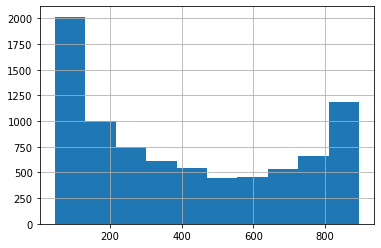

In [33]:
protein_expression_df.transpose().count().hist()

In [34]:
if dataset_name == "proteomicsdb":
    protein_expression_df_filtered = protein_expression_df.T.fillna(protein_expression_df.T.mean()).T
else:
    protein_expression_df_filtered = protein_expression_df.fillna(0)

## Or Filter out proteins with any NAs

In [35]:
# protein_expression_df_filtered = protein_expression_df[protein_expression_df.transpose().count() == protein_expression_df.shape[1]]

### Data statistics

In [36]:
protein_expression_df_filtered.describe()

TISSUE_TYPE;TISSUE_NAME;TISSUE_ID;SAMPLE_NAME,- Mixed PDB:200045 4Skin_mix1_4Skin_Fibro,- Mixed PDB:200045 4Skin_mix1_4Skin_iPS,- Mixed PDB:200045 4Skin_mix2_4Skin_Fibro,- Mixed PDB:200045 4Skin_mix2_4Skin_iPS,- Mixed PDB:200045 IMR90_mix1_IMR90_Fibro,- Mixed PDB:200045 IMR90_mix1_IMR90_iPS,- Mixed PDB:200045 gcpool_scxfrac_rep1,- Mixed PDB:200045 gcpool_scxfrac_rep2,- Mixed PDB:200045 gcpool_sdsfrac_rep1,- Mixed PDB:200045 gcpool_sdsfrac_rep2,...,Renal TK-10 BTO:0004283 P003203,Renal TK-10 BTO:0004283 TK10_NCI60,Renal U031 PDB:200456 U031_NCI60,Renal UO-31 BTO:0004234 P003201,Tongue CAL-27 BTO:0000921 P0001600-1,Tongue CAL-27 BTO:0000921 P0001600-2,Tongue CAL-27 BTO:0000921 P001602-1,Tongue CAL-27 BTO:0000921 P001602-2,Tongue CAL-27 BTO:0000921 P001613-1,Tongue CAL-27 BTO:0000921 P001613-2
count,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,...,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000,8189.000000
mean,4.845507,4.845507,4.873864,4.873864,4.728341,4.728341,5.068496,5.084695,5.088764,5.055029,...,4.977940,4.942421,5.014025,5.001832,5.001052,5.001052,4.976122,4.976122,4.985429,4.985429
std,1.006074,1.006074,1.012004,1.012004,1.026666,1.026666,0.754061,0.771735,0.783201,0.762679,...,0.820567,0.859182,0.790820,0.818545,0.807487,0.807487,0.834826,0.834826,0.815589,0.815589
min,0.768795,0.768795,1.184314,1.184314,1.068110,1.068110,2.903163,2.903163,2.903163,2.903163,...,2.292066,2.672462,2.903163,2.423188,2.193416,2.193416,2.140849,2.140849,2.290264,2.290264
25%,4.173701,4.173701,4.203829,4.203829,4.095864,4.095864,4.523057,4.531461,4.518826,4.508236,...,4.391781,4.310502,4.442573,4.422191,4.421854,4.421854,4.395712,4.395712,4.396227,4.396227
50%,4.834415,4.834415,4.881722,4.881722,4.719628,4.719628,5.023731,5.029206,5.027757,5.001579,...,4.901653,4.866563,4.934923,4.922963,4.915928,4.915928,4.892555,4.892555,4.893653,4.893653
75%,5.531182,5.531182,5.565591,5.565591,5.376883,5.376883,5.562161,5.580401,5.583854,5.540952,...,5.486892,5.497721,5.488759,5.500030,5.494502,5.494502,5.485678,5.485678,5.495764,5.495764
max,8.636913,8.636913,8.538984,8.538984,8.624907,8.624907,9.043688,8.777727,8.605225,8.693728,...,8.518963,8.483874,8.582291,8.160808,8.186421,8.186421,8.155933,8.155933,8.184406,8.184406


In [37]:
protein_expression_df_filtered.transpose().describe()

Gene_Symbol,A1BG,A2M,AAAS,AACS,AAGAB,AAK1,AAMP,AARS,AARS2,AARSD1,...,ZNRF2,ZPR1,ZRANB2,ZSCAN10,ZW10,ZWILCH,ZWINT,ZYG11B,ZYX,ZZEF1
count,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,...,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000
mean,5.316598,4.957777,4.957379,5.276159,5.222834,4.895028,5.511079,6.390548,4.902713,5.174140,...,4.881545,5.472332,5.860016,5.051478,5.027757,4.714187,5.081196,4.059910,6.099975,4.156531
std,0.215043,0.379532,0.516286,0.519194,0.398643,0.438980,0.426438,0.294941,0.541813,0.426756,...,0.223324,0.443216,0.566941,0.079952,0.394607,0.398480,0.455514,0.240774,0.421359,0.605456
min,3.880407,2.880900,2.665356,3.315700,3.203466,2.831874,3.858125,4.052608,2.763240,3.188714,...,3.403699,3.779338,3.788057,4.229083,3.287623,3.323831,2.746660,2.834298,3.656828,1.505440
25%,5.316598,4.957777,4.917170,5.081559,5.203890,4.801579,5.363772,6.263532,4.702202,4.990586,...,4.881545,5.222640,5.589462,5.051478,4.865755,4.714187,5.081196,4.059910,5.961694,4.156531
50%,5.316598,4.957777,4.957379,5.276159,5.222834,4.895028,5.511079,6.463258,4.902713,5.174140,...,4.881545,5.472332,5.892909,5.051478,5.027757,4.714187,5.081196,4.059910,6.107827,4.156531
75%,5.316598,4.957777,5.213962,5.681159,5.327520,5.087047,5.767349,6.584032,5.229255,5.455061,...,4.881545,5.775300,6.320462,5.051478,5.274450,4.714187,5.081196,4.059910,6.287153,4.161570
max,7.561032,7.132612,5.979183,6.285126,6.169612,5.802365,6.578121,6.975962,6.211206,6.054690,...,6.064906,6.394597,6.781251,5.677507,6.140561,5.793974,6.274673,5.288657,7.307064,5.869224


## Histograms

### First Sample

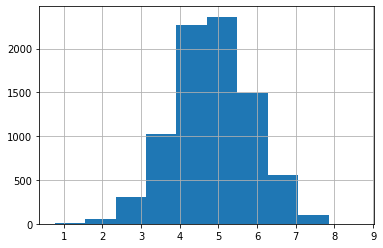

In [38]:
protein_expression_df_filtered.iloc[:, 1].hist()

### First Protein

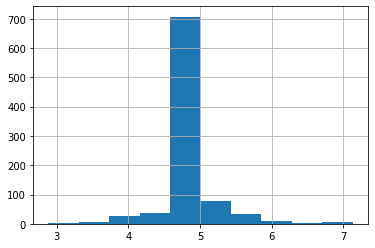

In [39]:
protein_expression_df_filtered.iloc[1, :].hist()

## Save Filtered Matrix

In [40]:
save(protein_expression_df_filtered, filepath, "proteomics_matrix_filtered_{}.tsv".format(dataset_name))

SAVED! ./data/proteomics_matrix_filtered_proteomicsdb.tsv


## Heatmap

In [41]:
protein_expression_df_filtered.shape

(8189, 913)

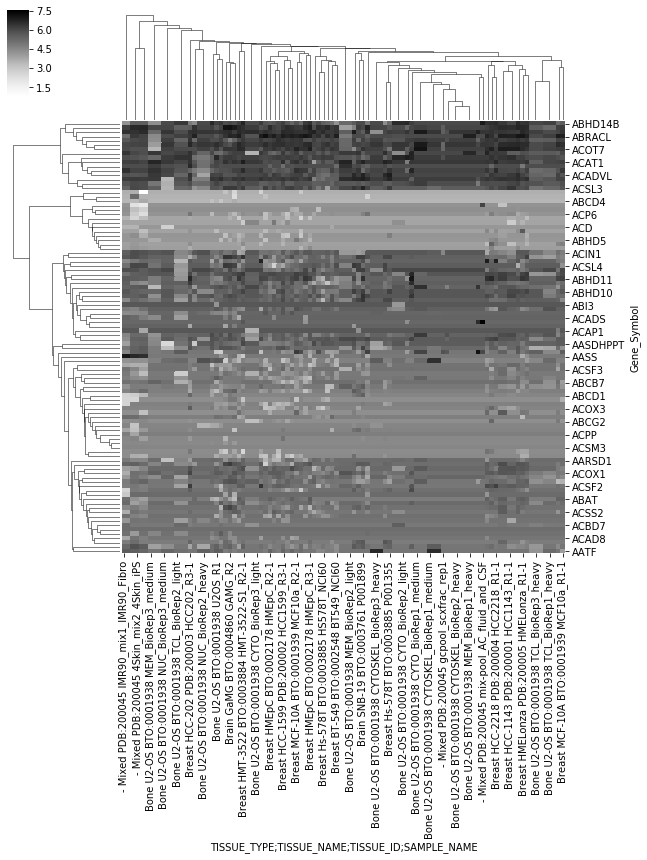

In [42]:
# ax = sns.clustermap(protein_expression_df_filtered, figsize=(10,10), cmap="Greys")
ax = sns.clustermap(protein_expression_df_filtered.iloc[:100,:100], figsize=(10,10), cmap="Greys")

## Create Tertiary matrix

In [43]:
def map_function(x, top_threshold, bottom_threshold):
    if x > top_threshold:
        return 1
    elif x < bottom_threshold:
        return -1
    else:
        return 0

In [44]:
k = 0.05
threshold_by_protein = protein_expression_df_filtered.quantile([k, 1-k], axis=1)
protein_expression_df_tertiary_matrix = protein_expression_df_filtered.copy()

for protein in protein_expression_df_filtered.index:
    row = protein_expression_df_filtered.loc[protein, :]
    threshold = threshold_by_protein.loc[:, protein]
    bottom_threshold = threshold.loc[k]
    top_threshold = threshold.loc[1-k]  
    row = row.apply(map_function, args=(top_threshold, bottom_threshold))
    protein_expression_df_tertiary_matrix.loc[protein, : ] = row



## Save Tertiary matrix

In [45]:
save(protein_expression_df_tertiary_matrix, filepath, "proteomics_tertiary_matrix_{}.tsv".format(dataset_name))

SAVED! ./data/proteomics_tertiary_matrix_proteomicsdb.tsv


## Create matrix of Standardized values (values between -1, and 1)

In [46]:
def createStandardizedMatrix(inputDF):
    df = inputDF.copy()

    for i,index in enumerate(inputDF.index):

        progressPercent = ((i+1)/len(inputDF.index))*100
        clear_output(wait=True)

        display("Progress: %d%%  %d Out of %d" % (progressPercent, (i+1), len(inputDF.index)))

        ourECDF = ECDF(df.loc[index])

        df.loc[index] = ourECDF(df.loc[index])

        mean = df.loc[index].values.flatten().mean()

        df.loc[index] = df.loc[index].apply(lambda x: 2*(x-mean))

    values = df.values.flatten()
    ourECDF = ECDF(values)

    ourECDF = ourECDF(values).reshape((len(df.index), len(df.columns)))

    newDF = pd.DataFrame(data = ourECDF, index=df.index, columns= df.columns)

    newDF.index.name = ''

    mean = newDF.values.flatten().mean()

    newDF = newDF.applymap(lambda x: 2*(x-mean))

    return(newDF)



In [47]:
standard_matrix = createStandardizedMatrix(protein_expression_df_filtered)

'Progress: 100%  8189 Out of 8189'

## Generate gene set library function

In [48]:
def genesetlibary(inputDF, up=True, by_tissue = True, details=None):
    result = []
    if by_tissue == False:
        inputDF = inputDF.T
    for i,col in enumerate(inputDF.columns):

        progressPercent = ((i+1)/len(inputDF.columns))*100      
        clear_output(wait=True)
        display("Progress: %d%%  %d Out of %d" % (progressPercent, (i+1), len(inputDF.columns)))

        if up == True:
            index = inputDF[inputDF[col] == 1].index
        else:
            index = inputDF[inputDF[col] == -1].index
        lst = index.values.tolist()

        if len(lst) > 5 and len(lst) <= 2000:
            lst.insert(0, col)
            if details:
                lst.insert(1, details[i])
            else:
                lst.insert(1, "\t")

            result.append(lst)
    return result



## Create Up gene set libary

In [49]:
up_gene_list = genesetlibary(protein_expression_df_tertiary_matrix, up = True, by_tissue=True)

'Progress: 100%  913 Out of 913'

In [50]:
save(up_gene_list, filepath, "gene_set_library_up_{}.gmt".format(dataset_name), is_list=True)

SAVED! ./data/gene_set_library_up_proteomicsdb.gmt


## Create Down gene set libary

In [51]:
down_gene_list = genesetlibary(protein_expression_df_tertiary_matrix, up = False, by_tissue=True)

'Progress: 100%  913 Out of 913'

In [52]:
save(down_gene_list, filepath, "gene_set_library_down_{}.gmt".format(dataset_name), is_list=True)

SAVED! ./data/gene_set_library_down_proteomicsdb.gmt


## Create Up attribute libtary

In [53]:
up_attribute_list = genesetlibary(protein_expression_df_tertiary_matrix, up = True, by_tissue=False)

'Progress: 100%  8189 Out of 8189'

In [54]:
save(up_attribute_list, filepath, "attribute_library_up_{}.gmt".format(dataset_name), is_list=True)

SAVED! ./data/attribute_library_up_proteomicsdb.gmt


## Create Down attribute libtary

In [55]:
down_attribute_list = genesetlibary(protein_expression_df_tertiary_matrix, up = False, by_tissue=False)

'Progress: 100%  8189 Out of 8189'

In [56]:
save(down_attribute_list, filepath, "attribute_library_down_{}.gmt".format(dataset_name), is_list=True)

SAVED! ./data/attribute_library_down_proteomicsdb.gmt


## Generate similarity matrix function

In [57]:
def get_similarity_matrix(df):
    gene_similarity_matrix = cosine_similarity(df)
    # print(gene_similarity_matrix.shape)
    newdf = pd.DataFrame(gene_similarity_matrix)

    newdf.index = df.index
    newdf.columns = df.index
    return newdf

## Create protein similarity matrix

In [58]:
protein_similarity_matrix = get_similarity_matrix(protein_expression_df_filtered)

## Create attribute similarity matrix

In [59]:
attribute_similarity_matrix = get_similarity_matrix(protein_expression_df_filtered.T)

## Heatmap of similarity matrix

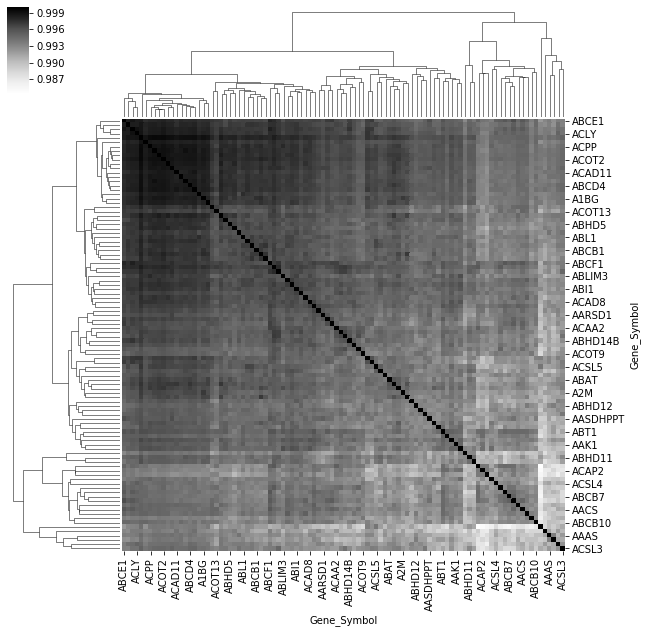

In [60]:
# ax = sns.clustermap(protein_similarity_matrix, figsize=(10,10), cmap="Greys")
ax = sns.clustermap(protein_similarity_matrix.iloc[:100, :100], figsize=(10,10), cmap="Greys")

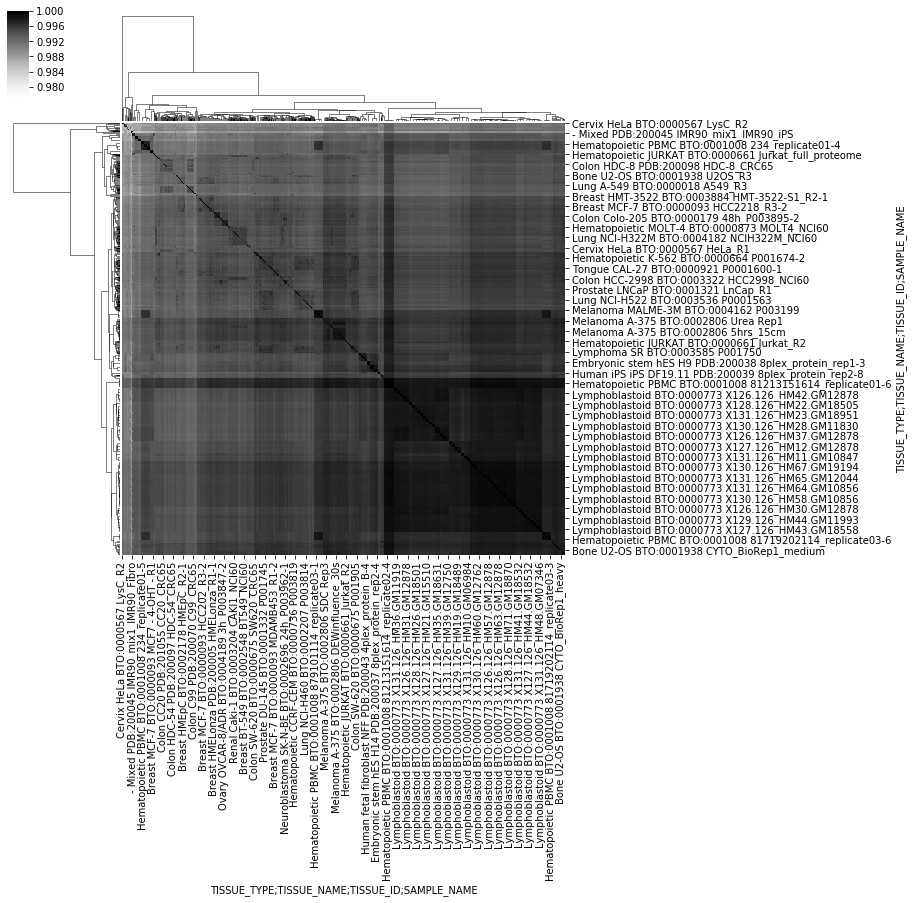

In [61]:
ax = sns.clustermap(attribute_similarity_matrix, figsize=(10,10), cmap="Greys")

## Save protein similarity matrix

In [62]:
save(protein_similarity_matrix, filepath, "proteomics_protein_similarity_matrix_{}.tsv".format(dataset_name))

SAVED! ./data/proteomics_protein_similarity_matrix_proteomicsdb.tsv


## Save attribute similarity matrix

In [63]:
save(attribute_similarity_matrix, filepath, "proteomics_attribute_similarity_matrix_{}.tsv".format(dataset_name))

SAVED! ./data/proteomics_attribute_similarity_matrix_proteomicsdb.tsv


## Create Gene List

In [64]:
if dataset_name == "proteomicsdb":
    gene_list = protein_id_df[["GeneSym", "Uniprot_Acc"]]
    gene_list.columns = ["GeneSym", "GeneID"]
    save(gene_list, filepath, "proteomics_gene_list_{}.tsv".format(dataset_name))

SAVED! ./data/proteomics_gene_list_proteomicsdb.tsv


## Create Attribute List

In [65]:
attribute_list = pd.DataFrame(protein_expression_df_filtered.columns)
attribute_list.columns = ["Attributes"]

In [66]:
attribute_list

,Attributes
0,- Mixed PDB:200045 4Skin_mix1_4Skin_Fibro
1,- Mixed PDB:200045 4Skin_mix1_4Skin_iPS
2,- Mixed PDB:200045 4Skin_mix2_4Skin_Fibro
3,- Mixed PDB:200045 4Skin_mix2_4Skin_iPS
4,- Mixed PDB:200045 IMR90_mix1_IMR90_Fibro
...,...
908,Tongue CAL-27 BTO:0000921 P0001600-2
909,Tongue CAL-27 BTO:0000921 P001602-1
910,Tongue CAL-27 BTO:0000921 P001602-2
911,Tongue CAL-27 BTO:0000921 P001613-1


## Save Attribute List

In [67]:
save(attribute_list, filepath, "proteomics_attribute_list_{}.tsv".format(dataset_name))

SAVED! ./data/proteomics_attribute_list_proteomicsdb.tsv


## Create Gene-Attribute Edge List

In [68]:
def createGeneAttributeEdgeList(inputDF, attributelist):

    count = 0

    col = ["GeneSym"]
    col.insert(2, 'Attribute')
    col.append('Weight')
    print(col)
    temp = pd.DataFrame(columns=col)
    col = ['{0}\t'.format(elem) for elem in col]
    col.insert(len(col), '\n')

    result = []
    for i,col in enumerate(inputDF.columns):

        progressPercent = ((i+1)/len(inputDF.columns))*100

        clear_output(wait=True)
        display("Progress: %d%%  %d Out of %d" % (progressPercent, (i+1), len(inputDF.columns)))


        temp['GeneSym'] = inputDF[col].index
        temp['Attribute'] = [col]*len(temp['GeneSym'])
        temp['Weight'] = inputDF[col].values.tolist()

        count += temp[temp['Weight'] >= 0.95].shape[0]
        count += temp[temp['Weight'] <= -0.95].shape[0]

        for index in temp.index:
            lst = [temp.loc[index, 'Attribute'], temp.loc[index, 'GeneSym'], temp.loc[index, 'Weight']]
            result.append(lst)
    print('\n\n The number of statisticaly relevent gene-attribute associations is: %d' %count)
    return result


In [ ]:
gene_attribute_edge_list = createGeneAttributeEdgeList(standard_matrix, attribute_list)

'Progress: 68%  623 Out of 913'

In [ ]:
gene_attribute_edge_df = pd.DataFrame(gene_attribute_edge_list)
gene_attribute_edge_df.columns = ["CellLine", "GeneSym", "Weight"]

In [ ]:
save(gene_attribute_edge_df, filepath, "proteomics_gene_attribute_edge_list_{}.tsv".format(dataset_name))